## Loading data

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from random import randint
from tqdm import tqdm
import zipfile
import os
import glob
import numpy as np 
import pandas as pd 

In [3]:
DATASET_PATH = Path('/kaggle/input/gan-getting-started/monet_jpg')
TO_BE_TRANSFORMED_DATASET_PATH = Path('/kaggle/input/gan-getting-started/photo_jpg')

In [4]:
df = keras.utils.image_dataset_from_directory(
   DATASET_PATH,
    color_mode='rgb',
    labels=None,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 300 files belonging to 1 classes.


In [5]:
normal_df = keras.utils.image_dataset_from_directory(
   TO_BE_TRANSFORMED_DATASET_PATH,
    color_mode='rgb',
    labels=None,
    batch_size=8,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 7038 files belonging to 1 classes.


## Preprocessing

In [6]:
def normalize_image(image):
    '''
    Normalize images in the interval -1, 1. 
    This normalization perform better on GANS than 0, 1
    standard normalization 
    '''
    return (image / 127.5) - 1

In [7]:
df = df.map(normalize_image)


## Image visualization

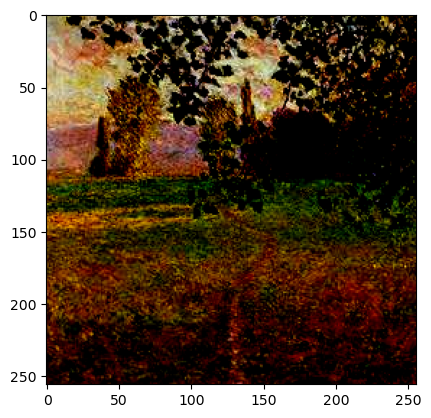

In [8]:
visual_data = list(df.as_numpy_iterator())[0]
plt.imshow(visual_data[randint(0, len(visual_data))])

## Models development

### Generator model

In [9]:
def build_generator():
    model = keras.Sequential()
    model.add(keras.layers.Dense(64*64*3, use_bias=False, input_shape=(100,))) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU()) #-1, 1 range output

    model.add(keras.layers.Reshape((64, 64, 3)))

    model.add(
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(5,5),
            strides=(1,1), 
            padding='same',
            use_bias=False
        )
    )
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(
        filters=16,
        kernel_size=(5,5),
        strides=(2,2),
        padding='same',
        use_bias=False
        )
    )
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(
        filters=3,
        kernel_size=(5,5),
        strides=(2,2),
        padding='same',
        use_bias=False,
        activation='tanh' #output for -1, 1 range
        )
    )

    model.summary()

    return model
    

In [10]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             1228800   
                                                                 
 batch_normalization (BatchN  (None, 12288)            49152     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12288)             0         
                                                                 
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 32)       2400      
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       1

In [11]:
noise = tf.random.normal([1, 100])

In [12]:
generated_image_test = generator(noise, training=False)

In [13]:
generated_image_test.shape

TensorShape([1, 256, 256, 3])

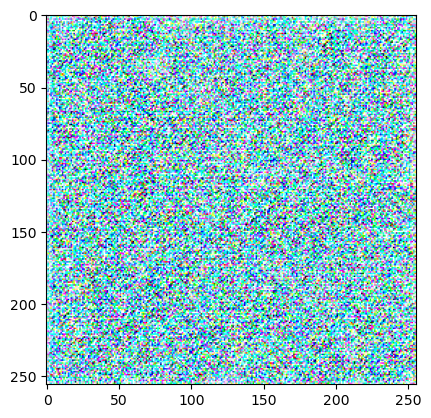

In [14]:
plt.imshow((generated_image_test[0] * 127.5) + 1)

### Discriminator model

In [15]:
def build_discriminator():
    model = keras.Sequential()
    model.add(
        keras.layers.Conv2D(
            filters=64,
            kernel_size=(5,5),
            strides=(2,2),
            padding='same',
            input_shape=(256,256,3)
        )
    )
    
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    
    model.add(
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(5,5),
            strides=(2,2),
            padding='same',
            input_shape=(256,256,3)
        )
    )
    
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(5,5),
            strides=(2,2),
            padding='same',
            input_shape=(256,256,3)
        )
    )
    
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    model.summary()
    return model

In [16]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        51232     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)       

In [17]:
discriminator(generated_image_test, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00211454]], dtype=float32)>

## GAN loss function

In [18]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [19]:
def discriminator_loss(original_painting, generated_painting):
    original_loss = cross_entropy(
        tf.ones_like(original_painting),
        original_painting
    )
    
    generated_loss = cross_entropy(
        tf.zeros_like(generated_painting),
        generated_painting
    )
    
    total_loss = original_loss + generated_loss
    return total_loss
    

### Generator loss

In [20]:
def generator_loss(generated_painting):
    return cross_entropy(
        tf.ones_like(generated_painting),
        generated_painting
    )

## Model training

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

In [22]:
noise_records = tf.random.normal([256, 100])

In [23]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([256, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # pass noise
        generated_images = generator(noise, training = True)

        # inputs discriminator
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        # calculates loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # get gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply gradient descent
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            train_steps(image_batch)

In [25]:
train(df, 400) 

  0%|          | 0/400 [00:00<?, ?it/s]2023-02-27 10:42:19.048860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-02-27 10:42:27.975472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
100%|██████████| 400/400 [31:47<00:00,  4.77s/it]


In [26]:
noise = tf.random.normal([1, 100])
result = generator(noise, training=False)

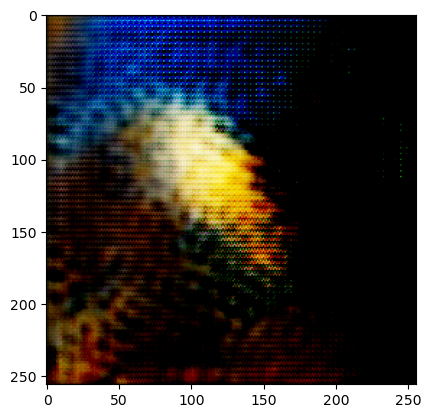

In [27]:
plt.imshow((result[0]))

## Saving generated images

In [28]:
def save_image(result, image_name):
    keras.preprocessing.image.save_img(image_name, result[0])

In [29]:
for c in tqdm(range(7500)):
    noise = tf.random.normal([1, 100])
    result = generator(noise, training=False)
    save_image(result, f'generated_image{c}.jpg')

100%|██████████| 7500/7500 [01:35<00:00, 78.56it/s]


In [30]:
with zipfile.ZipFile('images.zip', 'w') as f:
    for file in glob.glob('*.jpg'):
        f.write(file)

In [31]:
for file in glob.glob('*.jpg'):
    os.remove(file)